<a href="https://colab.research.google.com/github/mahidhiman12/Deep_learning_with_PyTorch/blob/main/6_PyTorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## What is a custom datasets?
- A custom dataset is a collection of data that a user or organization creates, defines, and tailors to their specific needs, rather than using a pre-existing, general-purpose dataset

- PyTorch Domain Libraries:
    - TorchVision - is this a photo of pizza or sushi ?
    - TorchText - Are these reviews positive or negative ?
    - TorchAudio - What song is playing ?
    - TorchRec - How do we recommend similar products?

Different domain libraries contain data loading functions for different data sources

- What we are going to cover ⁉
    - Getting custom dataset with PyTorch
    - Becoming one with the data (preparing and visualizing)
    - Transforming data for use with a model
    - Loading custom data with pre-built functions and custom functions
    - Building FoodVision Mini to classify images
    - Comparing models with and without data augmentation
    - Making predictions on custom data

In [1]:
# Import PyTorch
import torch
from torch import nn
torch.__version__

'2.8.0+cu126'

In [2]:
# set device agnostic code
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

1. Get data

- Our dataset is a subset of the Food101 dataset which is 101 dfferent classes of food and 1000 images per class (750 training , 250 testing)

- Our dataset starts with 3 classes of food (pizza , steak , sushi) and only 10% of the images (~75 training , ~25 testing)

- When starting out with ML projects . its important to try things on a small scale and then increase the scale when necessary

- The whole point is to speed up how fast you can experiment

In [3]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesnt exist , download it and prepare it ...
if image_path.is_dir():
  print(f"{image_path} directory already exists .. skipping download")
else:
  print(f"{image_path} does not exist , creating one..")
  image_path.mkdir(parents = True , exist_ok = True)

# Download the data
zip_file_path = data_path / "pizza_steak_sushi.zip"
with open(zip_file_path, 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza , steak , sushi data.. ")
  f.write(request.content)

# unzip pizza steak sushi file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
  print("Unzipping data file" )
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist , creating one..
Unzipping data file


## 2. Exploring and Preparing the data


In [4]:
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its contents. """
  for dirpath , dirnames , filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir , test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing

1. Get all of the image paths
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we are working with images , lets open the image with Python's PIL
5. We will then show the image and print metadata



In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path : data/pizza_steak_sushi/train/sushi/840444.jpg
Image class : sushi
Image height : 512
Image width : 512


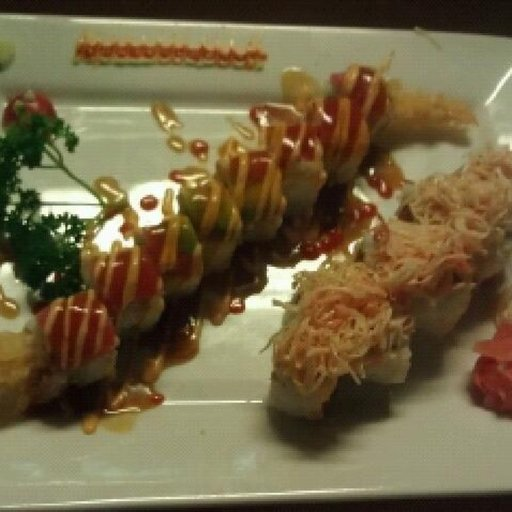

In [8]:
import random
from PIL import Image

# seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)


# 3. Get image class from path name (the image class is the name of directory where the image is stored)
image_class = random_image_path.parent.stem


# 4. open image using PIL
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height : {img.height}")
print(f"Image width : {img.width}")
img

### visualizing using matplotlib

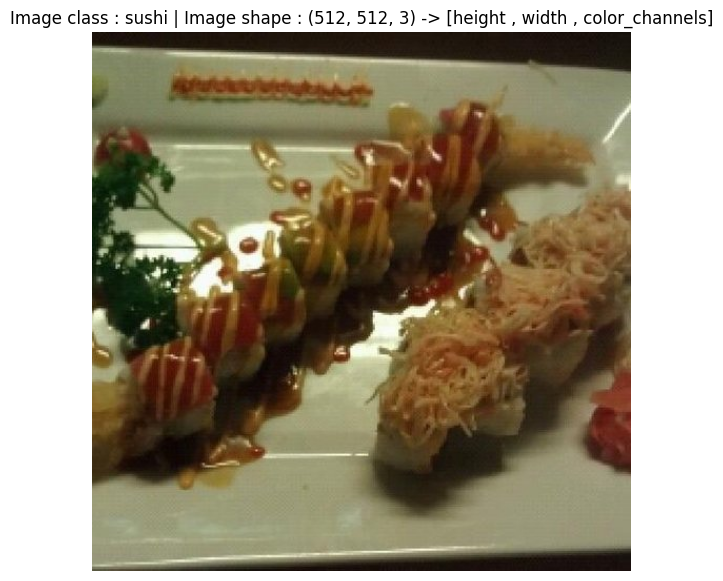

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# turn image into array
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class : {image_class} | Image shape : {img_as_array.shape} -> [height , width , color_channels]")
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case , numerical representation)
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader` , we will call these `Dataset` and `DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets , transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augmentation.

Transforms are common image transforms available in `torchvision.transforms` module.

They can be chained together using `Compose`

the transforms we want to perform are:

    1. resizing

    2. flip the image (data augmentation)

    3. Turn into tensor

In [11]:
# write a transform for image
data_transform = transforms.Compose([
    # resize
    transforms.Resize(size=(64,64)),
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # turn the image into a torch.tensor
    transforms.ToTensor()
])

In [12]:
print(f"Img shape before transform : {img.size}")
print(f"Img shape after transform : {data_transform(img).shape}")


Img shape before transform : (512, 512)
Img shape after transform : torch.Size([3, 64, 64])


### visualise transformed image

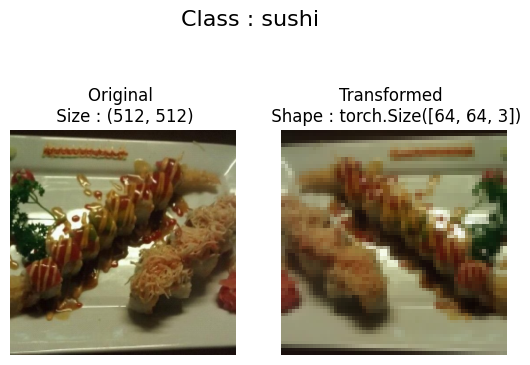

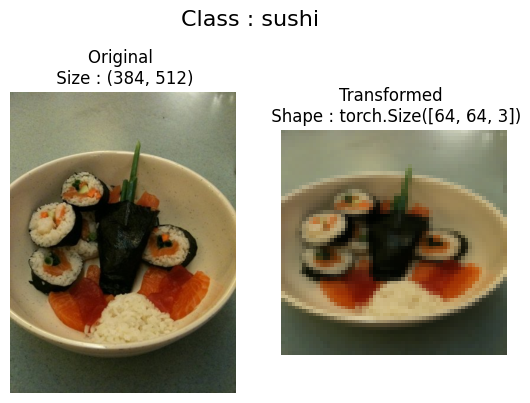

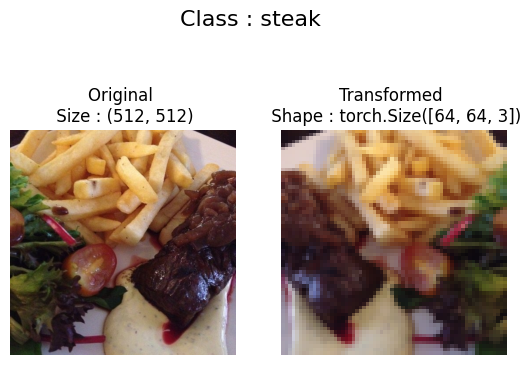

In [13]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  """ Selects random images from a path of images and loads/transforms them then
      plots the original vs the transformed version
  """
  random.seed(seed)
  random_image_paths = random.sample(image_paths , k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig , ax = plt.subplots(nrows = 1 , ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \n Size : {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      # permute changes order , bcs rn its (3,64,64) that will be a shape error
      # we can take 3 at the last by shuffling indices with permute
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Shape : {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class : {image_path.parent.stem}" , fontsize = 16)

plot_transformed_images(image_paths = image_path_list, transform=data_transform)

SEE that the pictures are more pixelated now because its 64,64 now when earlier it was 512 , 512

- After passing through the data transform these pictures are now
    - resized
    - flipped
    - converted to Tensors.

The most important thing will be does it still look like that to our model?

- Now , there is less information encoded in this image. So our model will compute faster on images of this size . However , we may loose some performance because not as much information is encoded as the original image

- Size is something that you can control . You can set it to be a hyper parameter. You can tune the size to see if it improves your model.

## 4. Option 1 : Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [14]:
from typing_extensions import dataclass_transform
from torchvision import datasets
train_data  = datasets.ImageFolder(root = train_dir,
                                   transform = data_transform, # transform for data
                                   target_transform = None) # Transform for target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform)

train_data , test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# index on the train_data Dataset to get a single image and label
# rndm_idx = torch.randint(0, len(train_data), size=())
# img , label = train_data[rndm_idx][0] , train_data[rndm_idx][1]
img , label = train_data[0][0] , train_data[0][1]
img
print(f"Image Tensor:\n{img}")
print(f"Image shape : {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label : {label} -> {class_names[label]}")

Image Tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

New shape : torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

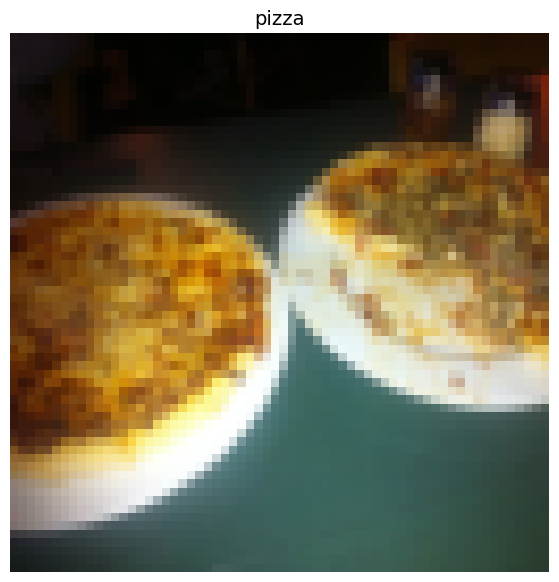

In [17]:
# plot using matplotlib
# rearrage the order dimensions because matplotlib likes color channels last
# [3, 64, 64] -> [64, 64, 3]

img_permute = img.permute(1,2,0)
print(f"New shape : {img_permute.shape}")

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label] , fontsize = 14)

### 4.1 Turning our image datasets into PyTorch DataLoaders

A DataLoader is going to help us turn our Dataset's into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time

In [18]:
import os
os.cpu_count()

2

In [19]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size= BATCH_SIZE,
                              num_workers =1,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                              batch_size= BATCH_SIZE,
                              num_workers =1,
                              shuffle=False)

# num workers -> the more the better , can set it to os.cpu_count()
# shuffle = False for test_dataloader bcs that if we want to evaluate our models
# later on , our test data set is always in the same order.

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a3da46df740>,
 <torch.utils.data.dataloader.DataLoader at 0x7a3da46eb650>)

In [20]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [21]:
len(train_data) , len(test_data)

(225, 75)

> NOTE : The next() function in PyTorch is primarily used in conjunction with iter() to retrieve individual batches of data from a DataLoader.

In [22]:
img , label = next(iter(train_dataloader))
print(f"image shape : {img.shape} -> [batch_size , c , h , w]")
print(f"label shape : {label.shape}")

image shape : torch.Size([1, 3, 64, 64]) -> [batch_size , c , h , w]
label shape : torch.Size([1])


Till now , we saw how to get our data from our data folder . We have got images of different food data here. And we are trying to get it into tensor format. So we have seen how to do that
with an existing data loader helper function or data set function in image folder.

However , what if image folder didnt exist? And we need to write our own custom data loading function.

- So lets replicate the functionality of image folder by creating our own data loading class.

So we want a few things ,
- Want to be able to load images from a file

- We want to be able to get the class names as a list from our loaded data

- We want want to be able to get our class names as a dictionary as well.

So the whole goal is to start writing a class thats capable of loading data from the data folder into tensor format , capable of being used with PyTorch's data loader class , like we have done before

Pros:
- Can create a `Dataset` out of almost anything
- Not limited to PyTorch pre-built `Dataset` functions

Cons:
- Even though you could create `Dataset` out of almost anything , it doesnt mean it will work
- Using a custom Dataset often results in us writing more code , which could be more prone to errors or performance issues

In [23]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple , Dict , List

In [24]:
train_data.classes , train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5. Option 2 : Loading Image data with a custom dataset

### 5.1 Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)

2. Raise an error if the class names arent found (if this happens , there might be something wrong with the directory structure )

3. Turn the class names into a dict and a list and return them

In [25]:
target_directory = train_dir
print(f"Target dir : {target_directory}")

# get class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

Now lets turn this functionality into a function

In [27]:
def find_classes(directory: str) -> Tuple[list[str] , Dict[str,int]]:
  """ Finds the class folder names in a target directory. Returns a Tuple
      and a dictionary. """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory} ... Pls check file structure")

  # 3. Create a dictionary of index labels (computers prefer numbers)
  class_to_idx = {class_name:i for i , class_name in enumerate(classes)}
  return classes , class_to_idx



In [28]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

A  map-style dataset is one that implements the __getitem__() and __len__() protocols, and represents a map from (possibly non-integral) indices/keys to data samples.

To create our own custom dataset , we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    - paths - paths of our images
    - transform - transform we'd like to use
    - classes - a list of the target classes
    - class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()` , this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [29]:
# 0. write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir:str,
               transform=None):
    # 3. Create class attributes
    # get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup transform
    self.transform = transform
    # create classes and class_to_idx attributes
    self.classes , self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_images(self, index:int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len()__ [optional]
  def __len__(self)->int:
    "Returns the total number of samples"
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self,index:int) -> Tuple[torch.Tensor , int]:
    "Returns one sample of data , data and label (X,y)"
    img = self.load_images(index)
    class_name = self.paths[index].parent.name
    # this expexts path in format : data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # transform if necessary
    if self.transform :
      return self.transform(img) , class_idx # return data , label (X,y)
    else:
      return img , class_idx # return untransformed image and label


In [30]:
# Create a transform

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [31]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)

In [32]:
train_data , train_data_custom , len(train_data) , len(train_data_custom)

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 225,
 225)

In [33]:
train_data_custom.classes , train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [34]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset

print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize

2. To prevent the display getting out of hand , lets cap the number of images to see at 10

3. Set the random seed for reproducibility

4. Get a list of random sample indexes from the target dataset

5. Set up a matplotlib plot

6. Loop through the random sample images and plot them with matplotlib

7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [35]:
# 1.
def display_random_images(dataset : torch.utils.data.Dataset,
                          classes : List[str] = None,
                          n : int = 10,
                          display_shape : bool = True,
                          seed : int = None):
  # 2. Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes , n shouldnt be larger than 10")

  # 3. Seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)),k=n)

  # 5. set up plot
  plt.figure(figsize=(24, 12))

  # 6. Loop through random indexes and plot
  for i , targ_sample in enumerate(random_samples_idx):
    targ_image , targ_label = dataset[targ_sample][0] , dataset[targ_sample][1]

    # 7. adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    # 8. plot
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class:{classes[targ_label]}"
      if display_shape:
        title = title + f" | Shape : {targ_image_adjust.shape}"

    plt.title(title)

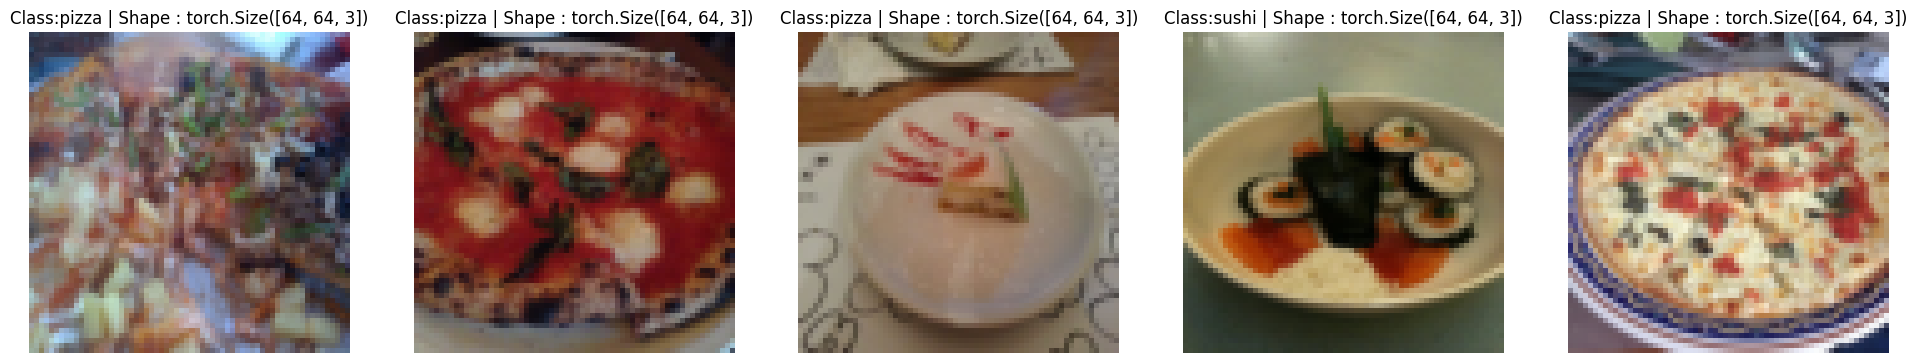

In [36]:
display_random_images(dataset=train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes , n shouldnt be larger than 10


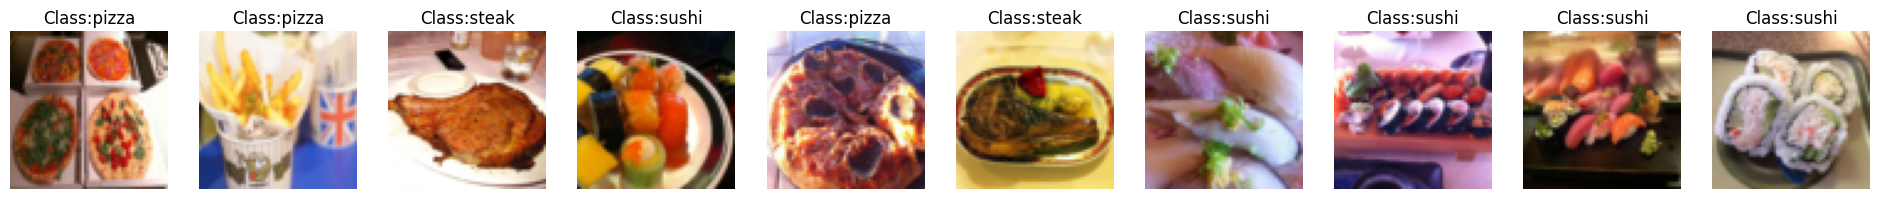

In [37]:
display_random_images(dataset=train_data_custom,
                      n=11,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`'s

- The `num_workers` will be what the number of CPU calls that we dedicate towards loading our data

The `num_workers` parameter in a dataloader, such as PyTorch's, specifies the number of subprocesses used for parallel data loading and preprocessing, significantly increasing data loading throughput and reducing GPU wait times. Setting `num_workers=0` loads data in the main process, creating a bottleneck, while a positive value creates parallel workers that load data into memory queues, allowing the main training process to work on the current batch without waiting for the next one to be loaded. To find the optimal value, start with `num_workers=0`, then gradually increase it, monitoring CPU usage and RAM consumption, as too many workers can become a bottleneck themselves

In [39]:
os.cpu_count()

2

In [40]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=0)

test_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

train_dataloader_custom , test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a3d91c13f50>,
 <torch.utils.data.dataloader.DataLoader at 0x7a3d9169aa80>)

In [41]:
# Get image and label from custom dataloader
img_custom , label_custom = next(iter(train_dataloader_custom))

# print out the shape
img_custom.shape , label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

**Data augmentation** is a technique used in machine learning to increase the size and diversity of a training dataset by creating modified copies of existing data. It artificially expands a dataset by applying various transformations, such as rotation, cropping, or adding noise to images, or back-translation for text, to make new, slightly altered versions. This helps improve model generalization and reduces overfitting by exposing the model to more variations of the data.

In [42]:
# trivialaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=3),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [43]:
image_path

PosixPath('data/pizza_steak_sushi')

In [44]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/542188.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1957449.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1209865.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1138695.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1129338.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1214108.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2641778.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/710379.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2323548.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3251688.jpg')]

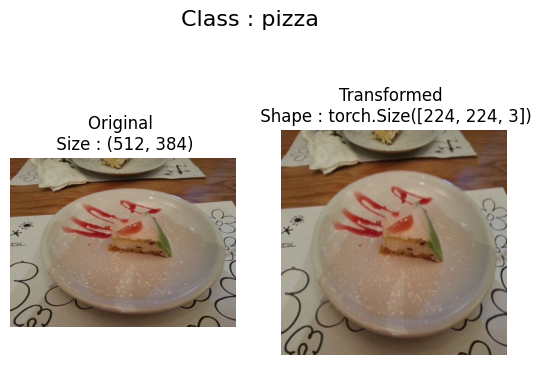

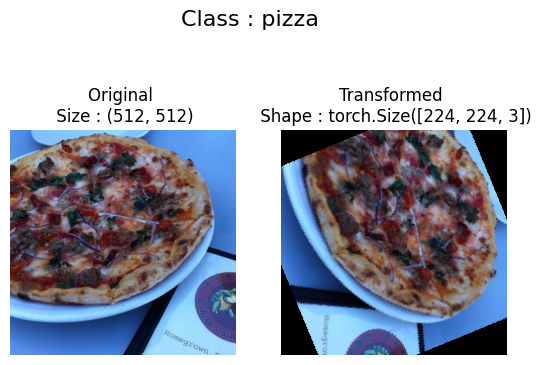

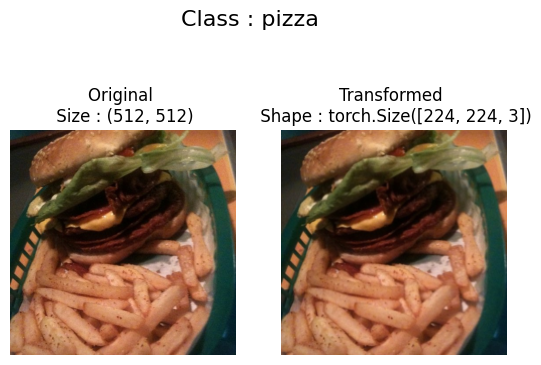

In [46]:
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n=3,
    seed=None
)

## 7. Model 0 : TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for model 0 - baseline model

In [48]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [49]:
# 1. Load and transform data
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform = simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform = simple_transform)

In [52]:
# 2. Turn the datasets into dataloaders
import os
from torch.utils.data import DataLoader

# setup batch size and num workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# create dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle=True,
                                     num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle=False,
                                     num_workers = NUM_WORKERS)

### 7.2 Create TinyVGG model class

- copying cnn explainer website

In [87]:
class TinyVGG(nn.Module):
  """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from CNN Explainer website"""

  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int)->None:

    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)

    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*13*13,
                  out_features = output_shape)
    )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [88]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape = 3,
                  hidden_units = 10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)

Dummy forward pass to check that our forward method is working correctly and that our input and output shapes are correct

In [89]:
# get a single image batch

image_batch , label_batch = next(iter(train_dataloader_simple))

image_batch.shape , label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [90]:
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [92]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [93]:

model = model_0
batch_size = BATCH_SIZE
summary(model , input_size=(batch_size , 3 , 64 , 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

### 7.5 Create train and test loop functions

In [95]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()
  train_loss , train_acc = 0,0
  for batch , (X,y) in enumerate(dataloader):
    X,y = X.to(device) , y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred , y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred , dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss , train_acc


- Accuracy:

`(y_pred_class == y).sum().item() / len(y_pred)` -> Total number that are right / len of samples

In [96]:
# create a test step

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device=device):
  model.eval()
  test_loss , test_acc = 0 , 0
  with torch.inference_mode():
    for batch , (X,y) in enumerate(dataloader):
      X,y = X.to(device) , y.to(device)
      test_pred_logits = model(X)
      loss = loss_fn(test_pred_logits , y)
      test_loss += loss.item()

      # accuracy
      test_pred_labels = torch.argmax(test_pred_logits , dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss , test_acc